In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.1.0
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.3
sklearn 0.22.1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]
print(x_train_all.shape, y_train_all.shape)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1, 28, 28, 1)

In [6]:
def make_dataset(images, labels, shuffle=True, batch_size=32):
    '''从内存中的tensor构造dateset'''
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [7]:
batch_size = 32
train_dataset = make_dataset(x_train_scaled, y_train, batch_size=batch_size)
valid_dataset = make_dataset(x_valid_scaled, y_valid, batch_size=batch_size)
test_dataset = make_dataset(x_test_scaled, y_test, batch_size=batch_size)

In [8]:

model = keras.models.Sequential()
# 经过3次卷积(2层3*3的卷积核)池化(1层)操作
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',
                              activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
          
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))

model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         7

In [10]:
log_dir = './logs'
if not os.path.exists(log_dir):
    os.mkdir(log_dir)
model_file = os.path.join(log_dir, 'fashion_mnist_model.h5')    

callbacks = [
    keras.callbacks.TensorBoard(log_dir),
    keras.callbacks.ModelCheckpoint(model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]
history = model.fit(train_dataset, epochs=10,
                    validation_data=valid_dataset,
                    steps_per_epoch=len(x_train_scaled) // batch_size,
                    validation_steps = len(x_valid_scaled) // batch_size,
                    callbacks=callbacks)

Train for 1718 steps, validate for 156 steps
Epoch 1/10
1718/1718 [==============================] - 65s 38ms/step - loss: 0.7913 - accuracy: 0.7180 - val_loss: 0.4290 - val_accuracy: 0.8470
Epoch 2/10
1718/1718 [==============================] - 65s 38ms/step - loss: 0.3943 - accuracy: 0.8535 - val_loss: 0.3768 - val_accuracy: 0.8602
Epoch 3/10
1718/1718 [==============================] - 67s 39ms/step - loss: 0.3373 - accuracy: 0.8753 - val_loss: 0.3017 - val_accuracy: 0.8886
Epoch 4/10
1718/1718 [==============================] - 76s 44ms/step - loss: 0.3044 - accuracy: 0.8874 - val_loss: 0.2996 - val_accuracy: 0.8900
Epoch 5/10
1718/1718 [==============================] - 78s 45ms/step - loss: 0.2806 - accuracy: 0.8961 - val_loss: 0.2833 - val_accuracy: 0.8986
Epoch 6/10
1718/1718 [==============================] - 80s 47ms/step - loss: 0.2616 - accuracy: 0.9031 - val_loss: 0.2934 - val_accuracy: 0.8930
Epoch 7/10
1718/1718 [==============================] - 81s 47ms/step - loss: 0

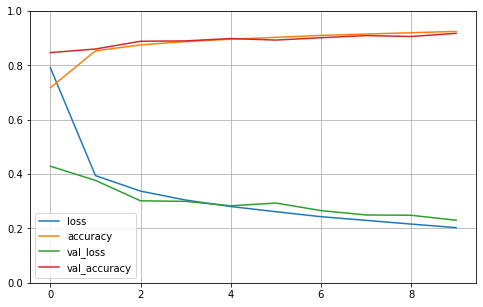

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
    
plot_learning_curves(history)

In [12]:
model.evaluate(test_dataset, steps=len(x_test_scaled) // batch_size)

312/312 [==============================] - 4s 13ms/step - loss: 0.2635 - accuracy: 0.9032


[0.2635096080768376, 0.9032452]